<a href="https://colab.research.google.com/github/guangyitan/face-mask-detector/blob/main/Image_Input_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [27]:
# import libraries
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [28]:
# declare the project path
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/'

# declare the model and weights parh of caffe model
prototxtPath = project_path + 'Res/deploy.prototxt'
weightsPath = project_path + 'Res/res10_300x300_ssd_iter_140000.caffemodel'

print(prototxtPath)
print(weightsPath)

/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Res/deploy.prototxt
/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Res/res10_300x300_ssd_iter_140000.caffemodel


In [29]:
# build the model
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [30]:
# load our mask classifying model
model = load_model('/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Saved_model')

In [73]:
# load the input image
imagePath = project_path + "Sample_Image/Sample2.jpg"
image=cv2.imread(imagePath)

In [75]:
image.shape

(1198, 800, 3)

In [76]:
# get the dimension of the image
(h,w)=image.shape[:2]

In [83]:
# resize the image to 300px x 300px
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))
print(blob.shape)

(1, 3, 300, 300)


In [80]:
# pass the blob into caffe model and get the face form the image
net.setInput(blob)
detections=net.forward()

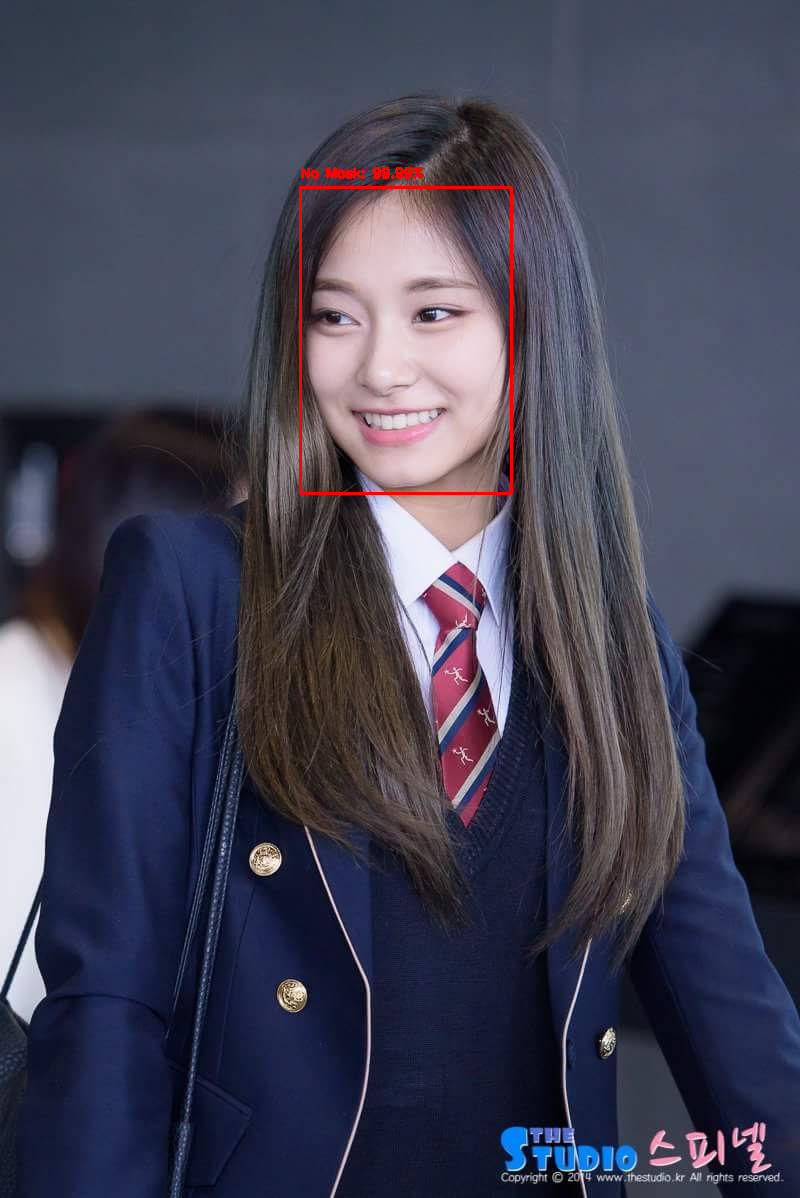

In [82]:
#loop over the detections
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    
    if confidence>0.5:
        #we need the X,Y coordinates
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0)
        
        (incorrectMask,mask,withoutMask)=model.predict(face)[0]
        
        label = ""
        color = (0,0,0)
        #determine the class label and color we will use to draw the bounding box and text
        if (incorrectMask > mask) and (incorrectMask > withoutMask):
          label = "Incorrect Mask"
          color = (240, 69, 50)
        
        elif (mask > incorrectMask) and (mask > withoutMask):
          label = "Mask"
          color = (0, 255, 0)

        else:
          label = 'No Mask'
          color = (0, 0, 255)
        
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(incorrectMask,mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
# display the output image
cv2_imshow(image)